In [1]:
from itertools import permutations
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import TransformerConv
from torch_geometric.data import Data
from torch_geometric.utils import negative_sampling, train_test_split_edges
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from scipy.spatial import distance_matrix
from scipy.special import softmax
from sklearn.metrics import roc_auc_score

In [2]:
def plot_xy(xy):
    plt.scatter(xy[:, 0], xy[:, 1], label=range(xy.shape[1]))
    plt.axis("off")

    
def plot_r(xy, r):
    plot_xy(xy)
    plt.plot(xy[r][:, 0], xy[r][:, 1])


def plot_rs(xy, rs, labels):
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for ax, r, label in zip(axes.flatten(), rs, labels):
        ax.set_title(label)
        ax.scatter(xy[:, 0], xy[:, 1], label=range(xy.shape[1]))
        ax.plot(xy[r][:, 0], xy[r][:, 1], label=label, alpha=0.5)

In [3]:
def length(d, r):
    return d[r[0:-1], r[1:]].sum()


def add(w, r, v):
    w[r[0:-1], r[1:]] += v


def sample(w, start_idx):
    N = w.shape[0]
    idx = start_idx
    unvisited = np.arange(N)
    route = []
    
    unvisited = np.delete(unvisited, np.where(unvisited == idx))
    route.append(idx)
        
    for i in range(N - 1):
        # Convert weights into probabilities
        p = softmax(w[idx][unvisited])
        
        # Select the next location acording to w
        idx = np.random.choice(unvisited, size=1, p=p)[0]
        
        # Delete the visited position
        unvisited = np.delete(unvisited, np.where(unvisited == idx))
        route.append(idx)
        
    return np.array(route)


def argmax_route(w, start_idx):
    N = w.shape[0]
    idx = start_idx

    route = [start_idx]

    unvisited = np.arange(N)
    unvisited = np.delete(unvisited, np.where(unvisited == idx))

    for i in range(N -1):
        max = w[idx][unvisited].max().item()
        idx = torch.where(w[idx] == max)[0].item()
        unvisited = np.delete(unvisited, np.where(unvisited == idx))
        route.append(idx)
    return np.array(route)


def brute_force(d):
    N = d.shape[0]
    min_length = 99999999
    best_route = None
    
    all_routes = set(permutations(range(N), N))
    for route in all_routes:
        route = np.array(route)
        if route[0] != 0:
            continue
        l = length(d, route)
        if l < min_length:
            min_length = l
            best_route = route

    return best_route

In [7]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Net, self).__init__()
        self.conv1 = TransformerConv(in_channels, 8, edge_dim=2)
        self.conv2 = TransformerConv(8, out_channels, edge_dim=2)
        self.mlp1 = Linear(out_channels * 2 + 2, 8)
        self.mlp2 = Linear(8, 1)

    def encode(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        return x

    def decode(self, z, edge_index, edge_attr):
        out = torch.cat((z[edge_index[0]], z[edge_index[1]], edge_attr), axis=1)
        out = self.mlp1(out)
        out = self.mlp2(out).squeeze()
        return out


def create_data(N):
    xy = torch.normal(0, 1, (N, 2))
    d = distance_matrix(xy, xy)
    route = brute_force(d)
    logd = 1 / np.log10(1 + d + 1e-7)
    np.fill_diagonal(logd, 0)
    logd = torch.tensor(logd.astype(np.float32))
    d = torch.tensor(d.astype(np.float32))
    
    neg_adj_mask = torch.zeros((N, N))
    neg_adj_mask[route[0:-1], route[1:]] = 1
    neg_adj_mask.fill_diagonal_(-1)
    all_edge_index=torch.stack(torch.where(neg_adj_mask != -1))
    data = Data(
        neg_edge_index=torch.stack(torch.where(neg_adj_mask == 0)),
        pos_edge_index=torch.stack(torch.where(neg_adj_mask == 1)),
        neg_adj_mask=neg_adj_mask,
        all_edge_index=all_edge_index,
        d=d,
        edge_attr=torch.cat([
            d[all_edge_index[0, :], all_edge_index[1, :]].unsqueeze(-1) - d.mean(),
            logd[all_edge_index[0, :], all_edge_index[1, :]].unsqueeze(-1) - logd.mean(),
        ],
            axis=1
        ),
        x=xy,
    )
    return data


def create_inference_data(N):
    xy = torch.normal(0, 1, (N, 2))
    return inference_data_from_xy(xy)


def inference_data_from_xy(xy):
    d = distance_matrix(xy, xy)
    N = d.shape[0]
    logd = 1 / np.log10(1 + d + 1e-7)
    np.fill_diagonal(logd, 0)
    logd = torch.tensor(logd.astype(np.float32))
    d = torch.tensor(d.astype(np.float32))
    
    neg_adj_mask = torch.zeros((N, N))
    all_edge_index=torch.stack(torch.where(neg_adj_mask != -1))
    data = Data(
        all_edge_index=all_edge_index,
        d=d,
        edge_attr=torch.cat([
            d[all_edge_index[0, :], all_edge_index[1, :]].unsqueeze(-1) - d.mean(),
            logd[all_edge_index[0, :], all_edge_index[1, :]].unsqueeze(-1) - logd.mean(),
        ],
            axis=1
        ),
        x=xy,
    )
    return data


N = 6
num_features=2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(num_features, 7).to(device)
dataset = [
    create_data(N).to(device) for _ in range(1000)
]
test_data = create_data(N)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

Epoch: 001, Loss: 0.3622, Val: 0.8640, Test: 0.8640
Epoch: 002, Loss: 0.3572, Val: 0.8640, Test: 0.8640
Epoch: 003, Loss: 0.3557, Val: 0.8880, Test: 0.8880
Epoch: 004, Loss: 0.3496, Val: 0.8720, Test: 0.8720
Epoch: 005, Loss: 0.3493, Val: 0.8720, Test: 0.8720
Epoch: 006, Loss: 0.3494, Val: 0.8720, Test: 0.8720
Epoch: 007, Loss: 0.3490, Val: 0.8720, Test: 0.8720
Epoch: 008, Loss: 0.3553, Val: 0.8720, Test: 0.8720
Epoch: 009, Loss: 0.3499, Val: 0.8720, Test: 0.8720
Epoch: 010, Loss: 0.3377, Val: 0.8720, Test: 0.8720
Epoch: 011, Loss: 0.3328, Val: 0.8800, Test: 0.8800
Epoch: 012, Loss: 0.3379, Val: 0.8720, Test: 0.8720
Epoch: 013, Loss: 0.3366, Val: 0.8720, Test: 0.8720
Epoch: 014, Loss: 0.3339, Val: 0.8720, Test: 0.8720
Epoch: 015, Loss: 0.3357, Val: 0.8880, Test: 0.8880
Epoch: 016, Loss: 0.3386, Val: 0.8960, Test: 0.8960
Epoch: 017, Loss: 0.3435, Val: 0.8720, Test: 0.8720
Epoch: 018, Loss: 0.3353, Val: 0.8960, Test: 0.8960
Epoch: 019, Loss: 0.3519, Val: 0.8880, Test: 0.8880
Epoch: 020, 

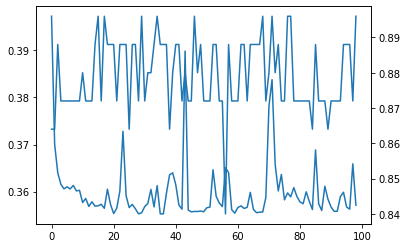

In [8]:
def get_link_labels(data):
    return data.neg_adj_mask[data.all_edge_index[0, :], data.all_edge_index[1, :]]


def train(data):
    model.train()

    optimizer.zero_grad()
    z = model.encode(data.x, data.all_edge_index, data.edge_attr)
    link_logits = model.decode(z, data.all_edge_index, data.edge_attr)
    link_labels = get_link_labels(data)
    loss = F.binary_cross_entropy_with_logits(link_logits, link_labels)
    loss.backward()
    optimizer.step()

    return loss


@torch.no_grad()
def test(data):
    model.eval()

    z = model.encode(data.x, data.all_edge_index, data.edge_attr)

    results = []
    for prefix in ['val', 'test']:
        pos_edge_index = data[f'pos_edge_index']
        neg_edge_index = data[f'neg_edge_index']
        link_logits = model.decode(z, data.all_edge_index, data.edge_attr)
        
        link_probs = link_logits.sigmoid()
        link_labels = get_link_labels(data)

        results.append(roc_auc_score(link_labels.cpu(), link_probs.cpu()))
    return results


losses = []
aucs = []
best_val_auc = test_auc = 0
for epoch in range(1, 100):
    total_loss = 0
    for data in dataset:
        loss = train(data)
        total_loss += loss.item()
    losses.append(total_loss / len(dataset))
    
    val_auc, tmp_test_auc = test(test_data)
    aucs.append(val_auc.item())
    
    if val_auc > best_val_auc:
        best_val = val_auc
        test_auc = tmp_test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')
    
fig, ax = plt.subplots()

ax.plot(losses)
ax2 = ax.twinx()
ax2.plot(aucs)
plt.show()

In [9]:
EPS = 1e-8

def brute(xy):
    d = distance_matrix(xy, xy)
    return brute_force(d)


def ants(xy):
    d = distance_matrix(xy, xy)
    N = d.shape[0]
    w = 1 / (d + EPS)
    np.fill_diagonal(w, 0)
    lengths = []
    ws = []
    total = 0
    count = 0
    best_r = None
    min_l = 9999999999
    for iteration in range(2000):
        r = sample(w, np.random.randint(0, N, size=(1,))[0])
        l = length(d, r)
        total += l
        total *= 0.98
        count += 1
        count *= 0.98
        lengths.append(l)
        ws.append(w.copy())
        mean = total / count
        add(w, r, (mean - l) / N)
        if l < min_l:
            min_l = l
            best_r = r
    return argmax_route(torch.tensor(w), 0)


def nn(xy):
    data = inference_data_from_xy(xy)
    z = model.encode(data.x, data.all_edge_index, data.edge_attr)
    w = model.decode(z, data.all_edge_index, data.edge_attr)
    wm = torch.zeros_like(data.d)
    wm[data.all_edge_index[0, :], data.all_edge_index[1, :]] = w
    wm = wm.squeeze(0).detach()
    return argmax_route(wm, 0)

brute
ants
nn


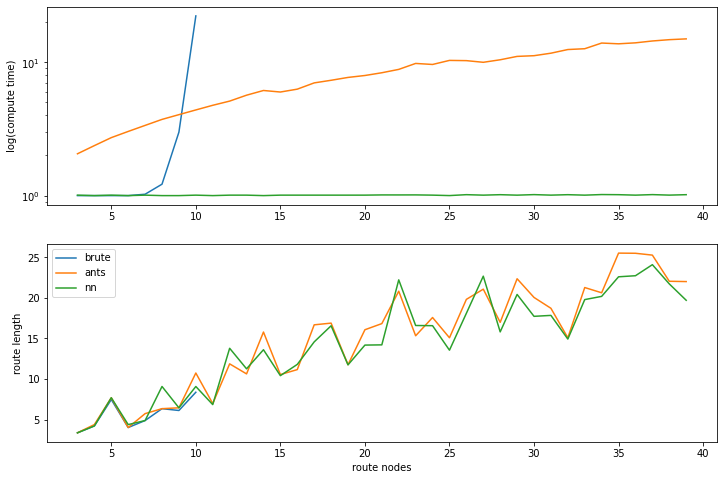

In [10]:
algorithms = [brute, ants, nn]
ns = list(range(3, 40))
xys = [torch.normal(0, 1, (n, 2)) for n in ns]

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

for f in algorithms:
    print(f.__name__)
    ls = []
    ts = []
    subns = []
    for n, xy in zip(ns, xys):
        if n > 10 and f.__name__ == "brute":
            break
        d = distance_matrix(xy, xy)
        start = datetime.now()
        route = f(xy)
        ts.append(1 + (datetime.now() - start).total_seconds())
        ls.append(length(d, route))
        subns.append(n)
        
    axes[0].plot(subns, ts, label=f.__name__)
    axes[0].set_yscale('log')
    axes[0].set_ylabel('log(compute time)')
    axes[1].plot(subns, ls, label=f.__name__)
    axes[1].set_ylabel('route length')
    axes[1].set_xlabel('route nodes')

plt.legend()
plt.show()

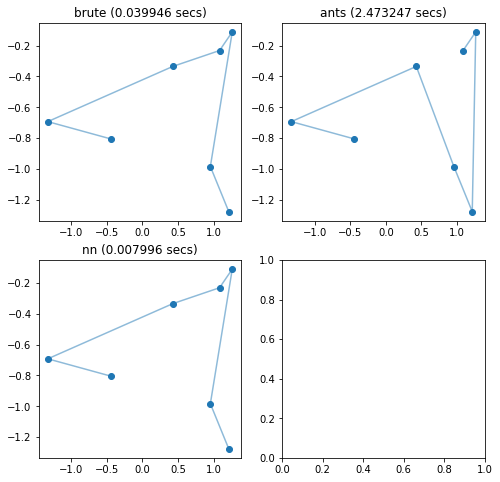

In [11]:
xy = xys[4]
rs = []
labels = []
ts = []
for f in algorithms:
    start = datetime.now()
    route = f(xy)
    t = datetime.now() - start
    labels.append(f"{f.__name__} ({t.total_seconds()} secs)")
    rs.append(route)
    
plot_rs(xy, rs, labels)

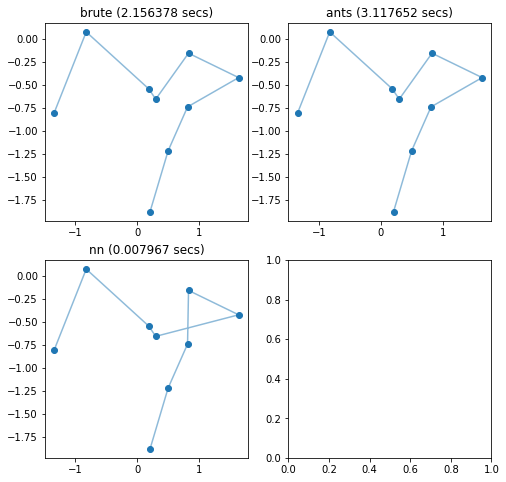

In [12]:
xy = xys[6]
rs = []
labels = []
ts = []
for f in algorithms:
    start = datetime.now()
    route = f(xy)
    t = datetime.now() - start
    labels.append(f"{f.__name__} ({t.total_seconds()} secs)")
    rs.append(route)
    
plot_rs(xy, rs, labels)


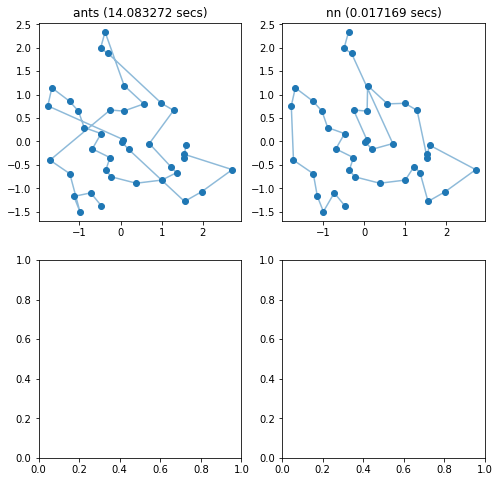

In [13]:
xy = xys[-1]
rs = []
labels = []
ts = []
for f in algorithms:
    if f.__name__ == "brute":
        continue
    start = datetime.now()
    route = f(xy)
    t = datetime.now() - start
    labels.append(f"{f.__name__} ({t.total_seconds()} secs)")
    rs.append(route)
    
plot_rs(xy, rs, labels)
